In [1]:
# Import python libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from scipy.special import erf
import pandas as pd

# Import the CCM modules
import leptoninjector as LI

In [ ]:
# Make an instance of random for use 
random = LI.utilities.LI_random()

# HNL parameters
hnl_mass_str = "0.02035" # make sure this matches one of the cross section tables
hnl_mass = float(hnl_mass_str) # GeV
d_dipole = 5e-7 # GeV^-1

# Injection parameters
events_to_inject = int(1e5)
primary_type = LI.dataclasses.Particle.ParticleType.NuMu

# For upscattering cross section
z_samp = False
inv_GeV = True
inelastic = True
target_types = [LI.dataclasses.Particle.ParticleType.HNucleus,
                LI.dataclasses.Particle.ParticleType.Be9Nucleus,
                LI.dataclasses.Particle.ParticleType.C12Nucleus,
                LI.dataclasses.Particle.ParticleType.N14Nucleus,
                LI.dataclasses.Particle.ParticleType.O16Nucleus,
                LI.dataclasses.Particle.ParticleType.Na23Nucleus,
                LI.dataclasses.Particle.ParticleType.Al27Nucleus,
                LI.dataclasses.Particle.ParticleType.Si28Nucleus,
                LI.dataclasses.Particle.ParticleType.Ar40Nucleus,
                LI.dataclasses.Particle.ParticleType.Ca40Nucleus,
                LI.dataclasses.Particle.ParticleType.Mn55Nucleus,
                LI.dataclasses.Particle.ParticleType.Fe56Nucleus,
                LI.dataclasses.Particle.ParticleType.Cu63Nucleus,
                LI.dataclasses.Particle.ParticleType.Cu65Nucleus,
                LI.dataclasses.Particle.ParticleType.W183Nucleus,
                LI.dataclasses.Particle.ParticleType.Pb208Nucleus]
ZA_combos = [[1,1],
             [4,9],
             [6,12],
             [7,14],
             [8,16],
             [11,23],
             [13,27],
             [14,28],
             [18,40],
             [20,40],
             [25,55],
             [26,56],
             [29,63],
             [29,65],
             [74,183],
             [82,208]]
# file locations
tot_xsec_path = '../../../../Sandbox/Dipole_xsec_tables/tot_xsec_E0_Ne20'
diff_xsec_path = '../../../../Sandbox/Dipole_xsec_tables/diff_xsec_y_Enu_0.055_Ne20'
tot_hf_files = ['%s/xsec_Z_%i_A_%i_mHNL_%s_hf.dat'%(tot_xsec_path,
                                                    Z,A,
                                                    hnl_mass_str) for Z,A in ZA_combos]
tot_hc_files = ['%s/xsec_Z_%i_A_%i_mHNL_%s_hc.dat'%(tot_xsec_path,
                                                    Z,A,
                                                    hnl_mass_str) for Z,A in ZA_combos]
diff_hf_files = ['%s/dxsec_Z_%i_A_%i_mHNL_%s_hf.dat'%(diff_xsec_path,
                                                      Z,A,
                                                      hnl_mass_str) for Z,A in ZA_combos]
diff_hc_files = ['%s/dxsec_Z_%i_A_%i_mHNL_%s_hc.dat'%(diff_xsec_path,
                                                      Z,A,
                                                      hnl_mass_str) for Z,A in ZA_combos]

# For comparing data to HNL prediction later on
CCM200_POT = 2.25e22
CCM120_POT = 1.79e21
bkg_reduction_factor = 1e-2 # optimistic, with Chrenkov reconstruction working
pe_to_MeV = 0.1
WorkshopToolsDir = '../../../../Sandbox/' # Change this if need be

In [ ]:
target_types = [LI.dataclasses.Particle.ParticleType.C12Nucleus,
                LI.dataclasses.Particle.ParticleType.N14Nucleus,
                LI.dataclasses.Particle.ParticleType.O16Nucleus,
                LI.dataclasses.Particle.ParticleType.Si28Nucleus,
                LI.dataclasses.Particle.ParticleType.Fe56Nucleus]

### Add geometry

In [5]:
# Make the earth model, add CCM detector layout and materials file

materials_file = '../earthparams/materials/ATLAS.dat'
earth_model_file = '../earthparams/densities/PREM_ATLAS.dat'

earth_model = LI.detector.EarthModel()
earth_model.LoadMaterialModel(materials_file)
earth_model.LoadEarthModel(earth_model_file)

### Define injection processes

In [7]:
# Define injection processes for each target
primary_injection_process_upper_target = LI.injection.InjectionProcess()
#primary_injection_process_lower_target = LI.injection.InjectionProcess()
secondary_injection_processes = []
primary_injection_process_upper_target.primary_type = primary_type
#primary_injection_process_lower_target.primary_type = primary_type

# Define physical processes for each target
primary_physical_process_upper_target = LI.injection.PhysicalProcess()
#primary_physical_process_lower_target = LI.injection.PhysicalProcess()
secondary_physical_processes = []
primary_physical_process_upper_target.primary_type = primary_type
#primary_physical_process_lower_target.primary_type = primary_type



### Construct Cross Section Classes

In [8]:
# Define upscattering cross section classes

cross_sections = []
hf_xs = LI.crosssections.DipoleFromTable(hnl_mass,
                                      d_dipole,
                                      LI.crosssections.DipoleFromTable.HelicityChannel.Flipping,
                                      z_samp,inv_GeV,inelastic)
hc_xs = LI.crosssections.DipoleFromTable(hnl_mass,
                                      d_dipole,
                                      LI.crosssections.DipoleFromTable.HelicityChannel.Conserving,
                                      z_samp,inv_GeV,inelastic)
for i in range(len(target_types)):
    hf_xs.AddTotalCrossSectionFile(tot_hf_files[i],target_types[i])
    hf_xs.AddDifferentialCrossSectionFile(diff_hf_files[i],target_types[i])
    hc_xs.AddTotalCrossSectionFile(tot_hc_files[i],target_types[i])
    hc_xs.AddDifferentialCrossSectionFile(diff_hc_files[i],target_types[i])

cross_sections.append(hf_xs)
cross_sections.append(hc_xs)
primary_cross_sections = LI.crosssections.CrossSectionCollection(primary_type, cross_sections)
primary_injection_process_upper_target.SetCrossSections(primary_cross_sections)
primary_injection_process_lower_target.SetCrossSections(primary_cross_sections)
primary_physical_process_upper_target.SetCrossSections(primary_cross_sections)
primary_physical_process_lower_target.SetCrossSections(primary_cross_sections)



### Construct Energy Distributions

In [9]:
# Energy distribution: monoenergetic neutrino from pion decay at rest

nu_energy = 0.02965 # from pi+ DAR
edist = LI.distributions.Monoenergetic(nu_energy)
primary_injection_process_upper_target.AddInjectionDistribution(edist)
primary_injection_process_lower_target.AddInjectionDistribution(edist)
primary_physical_process_upper_target.AddPhysicalDistribution(edist)
primary_physical_process_lower_target.AddPhysicalDistribution(edist)

# Flux normalization: 
# using the number quoted in 2105.14020, 4.74e9 nu/m^2/s / (6.2e14 POT/s) * 4*pi*20m^2 to get nu/POT
flux_units = LI.distributions.NormalizationConstant(3.76e-2)
primary_physical_process_upper_target.AddPhysicalDistribution(flux_units)
primary_physical_process_lower_target.AddPhysicalDistribution(flux_units)


### Construct Direction Distributions

In [10]:
# Primary direction: A cone around CCM

opening_angle = np.arctan(12/23.); # slightly larger than CCM
upper_target_origin = LI.math.Vector3D(0, 0, 0.1375)
lower_target_origin = LI.math.Vector3D(0, 0, -0.241)
detector_origin = LI.math.Vector3D(23, 0, -0.65)
upper_dir = detector_origin - upper_target_origin
upper_dir.normalize()
lower_dir = detector_origin - lower_target_origin
lower_dir.normalize()
upper_inj_ddist = LI.distributions.Cone(upper_dir,opening_angle)
lower_inj_ddist = LI.distributions.Cone(lower_dir,opening_angle)
phys_ddist = LI.distributions.IsotropicDirection() # truly we are isotropic
primary_injection_process_upper_target.AddInjectionDistribution(upper_inj_ddist)
primary_injection_process_lower_target.AddInjectionDistribution(lower_inj_ddist)
primary_physical_process_upper_target.AddPhysicalDistribution(phys_ddist)
primary_physical_process_lower_target.AddPhysicalDistribution(phys_ddist);


### Some other trivial specifications: target at rest, neutrinos, positions

In [11]:
# Target momentum distribution: target is at rest

target_momentum_distribution = LI.distributions.TargetAtRest()
primary_injection_process_upper_target.AddInjectionDistribution(target_momentum_distribution)
primary_injection_process_lower_target.AddInjectionDistribution(target_momentum_distribution)
primary_physical_process_upper_target.AddPhysicalDistribution(target_momentum_distribution)
primary_physical_process_lower_target.AddPhysicalDistribution(target_momentum_distribution)


In [12]:
# Helicity distribution: primary neutrino helicity

helicity_distribution = LI.distributions.PrimaryNeutrinoHelicityDistribution()
primary_injection_process_upper_target.AddInjectionDistribution(helicity_distribution)
primary_injection_process_lower_target.AddInjectionDistribution(helicity_distribution)
primary_physical_process_upper_target.AddPhysicalDistribution(helicity_distribution)
primary_physical_process_lower_target.AddPhysicalDistribution(helicity_distribution)


In [13]:
# Position distribution: consider neutrinos from a point source

max_dist = 25
upper_pos_dist = LI.distributions.PointSourcePositionDistribution(upper_target_origin, max_dist, primary_cross_sections.TargetTypes())
lower_pos_dist = LI.distributions.PointSourcePositionDistribution(lower_target_origin, max_dist, primary_cross_sections.TargetTypes())
primary_injection_process_upper_target.AddInjectionDistribution(upper_pos_dist)
primary_injection_process_lower_target.AddInjectionDistribution(lower_pos_dist)


In [14]:
# Secondary process definition

secondary_decay_injection_process = LI.injection.InjectionProcess()
secondary_decay_physical_process = LI.injection.PhysicalProcess()
secondary_decay_injection_process.primary_type = LI.dataclasses.Particle.ParticleType.NuF4
secondary_decay_physical_process.primary_type = LI.dataclasses.Particle.ParticleType.NuF4


In [15]:
# Secondary cross section class: HNL decay

sec_decay = LI.crosssections.NeutrissimoDecay(hnl_mass, d_dipole, LI.crosssections.NeutrissimoDecay.ChiralNature.Majorana)
secondary_cross_sections = LI.crosssections.CrossSectionCollection(LI.dataclasses.Particle.ParticleType.NuF4, [sec_decay])
secondary_decay_injection_process.SetCrossSections(secondary_cross_sections)
secondary_decay_physical_process.SetCrossSections(secondary_cross_sections)

In [16]:
# Secondary position distribution

secondary_pos_dist = LI.distributions.SecondaryPositionDistribution()
for sector in earth_model.GetSectors():
    if sector.name=='ccm_inner_argon':
        fid_vol = sector.geo
        secondary_pos_dist = LI.distributions.SecondaryPositionDistribution(sector.geo)

secondary_decay_injection_process.AddInjectionDistribution(secondary_pos_dist)

secondary_injection_processes.append(secondary_decay_injection_process)
secondary_physical_processes.append(secondary_decay_physical_process)



In [17]:
# Put it all together! One injector for each W target
upper_injector = LI.injection.InjectorBase(events_to_inject, earth_model, 
                                        primary_injection_process_upper_target, 
                                        secondary_injection_processes,
                                        random)

lower_injector = LI.injection.InjectorBase(events_to_inject, earth_model, 
                                        primary_injection_process_lower_target, 
                                        secondary_injection_processes,
                                        random)

# stopping condition for interaction tree generation
#
# this function should return true if the input datum should terminate
# the simulation for the current branch of the interaction
#
# for this test, stop after any secondary interaction tree datum is created
def StoppingCondition(datum):
    return True

upper_injector.SetStoppingCondition(StoppingCondition)
lower_injector.SetStoppingCondition(StoppingCondition)


In [18]:
# Weighter instances, one for each target

upper_weighter = LI.injection.LeptonTreeWeighter([upper_injector],
                                              earth_model, 
                                              primary_physical_process_upper_target, 
                                              secondary_physical_processes)
lower_weighter = LI.injection.LeptonTreeWeighter([lower_injector],
                                              earth_model, 
                                              primary_physical_process_upper_target, 
                                              secondary_physical_processes)



In [19]:
c = 2.998e-1 #m/ns

gamma_energy_list = []
gamma_weight_list = []
gamma_time_list = []

# generate evenents in lower target
while lower_injector.InjectedEvents() < events_to_inject:
    print(lower_injector.InjectedEvents(),end='\r')
    tree = lower_injector.GenerateEvent() # generate the interaction tree
    weight = lower_weighter.EventWeight(tree) # calculate the event weight for this tree
    time = 0
    for datum in tree.tree: # loop over interactions in the tree
        if(datum.record.signature.primary_type == LI.dataclasses.Particle.ParticleType.NuMu):
            # calculate travel time of speed of light neutrino
            dist = LI.math.Vector3D(datum.record.interaction_vertex) - lower_target_origin
            time += dist.magnitude()/c
        if(datum.record.signature.primary_type == LI.dataclasses.Particle.ParticleType.NuF4):
            # calculate travel time of non-ultra-relativistic HNL
            dist = LI.math.Vector3D(datum.record.interaction_vertex) - LI.math.Vector3D(datum.parent.record.interaction_vertex)
            gamma = datum.record.primary_momentum[0]/datum.record.primary_mass
            beta = np.sqrt(1 - (1/gamma)**2)
            time += dist.magnitude()/(beta*c)

            # figure out if we're in the fiducial volume
            HNL_vtx = LI.math.Vector3D(datum.record.interaction_vertex)
            HNL_dir = LI.math.Vector3D(datum.record.primary_momentum[1:])
            HNL_dir.normalize()
            if(fid_vol.IsInside(HNL_vtx,HNL_dir)):

                # Save the energy of the gamma
                for sID,sP in zip(datum.record.signature.secondary_types,
                                  datum.record.secondary_momenta):
                    if(sID==LI.dataclasses.Particle.ParticleType.Gamma):
                        gamma_energy_list.append(sP[0]*1e3)
                        gamma_weight_list.append(weight)

    # if this is a fiducial event, save the travel time
    if(fid_vol.IsInside(HNL_vtx,HNL_dir)):
        gamma_time_list.append(time - 23./c)

Index(['binLowEdge', 'binWidth', 'DataValue', 'DataError',
       'BackgroundPrediction', 'BackgroundError', 'Subtraction',
       'SubtractionError'],
      dtype='object')


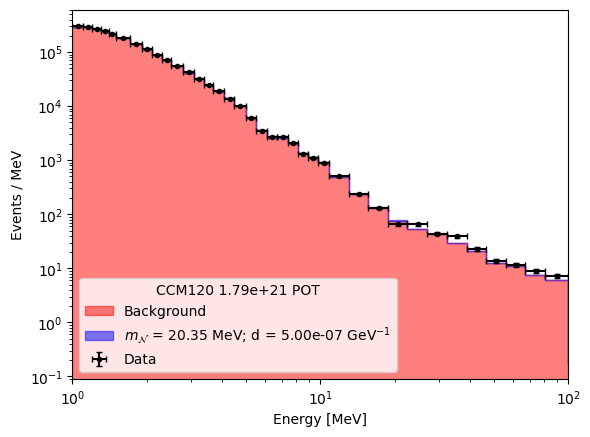

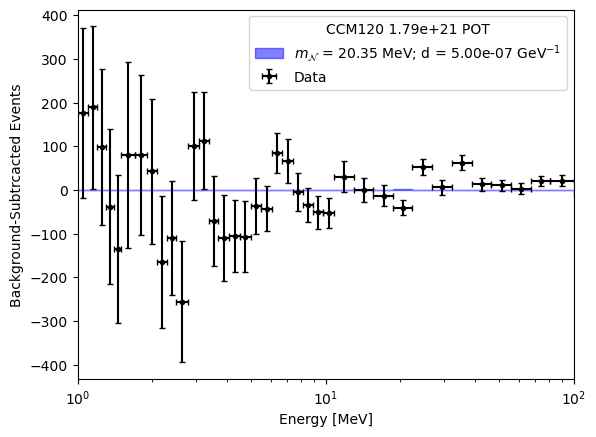

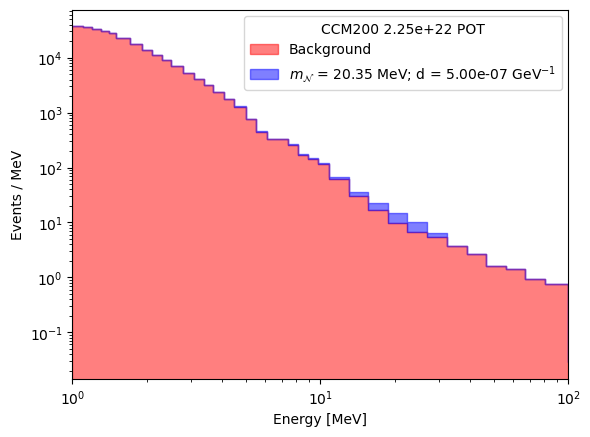

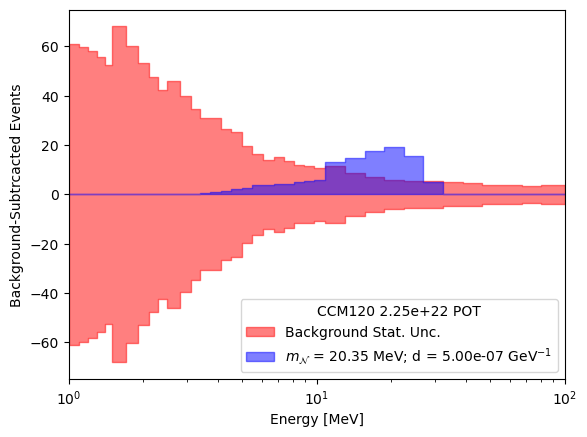

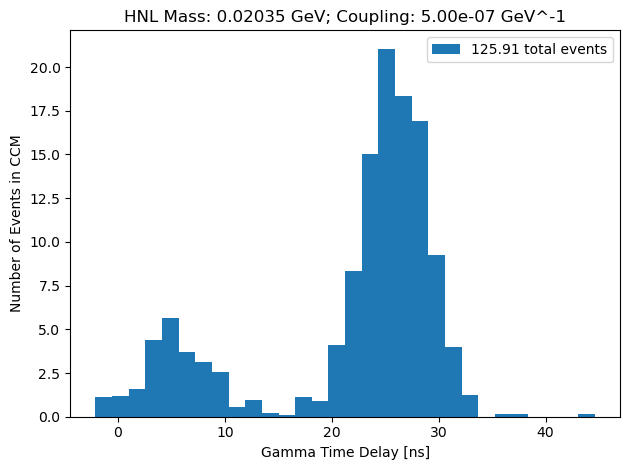

In [20]:
# Class for energy smearing: assumes 15% uncertainty on energy reconstruction
class EnergySmearingGaus:
  
    def __init__(self,gamma_energies,
                    gamma_weights,
                    res=0.15):
        self.gamma_energies = gamma_energies
        self.gamma_weights = gamma_weights
        self.res = res

    def Gaus(self,x,mu,std_dev):
        return 1./np.sqrt(2*np.pi*std_dev**2)*np.exp(-(x-mu)**2/(2*std_dev**2))

    def smeared_rate(self,E):
        ret = 0
        for e,w in zip(self.gamma_energies,self.gamma_weights):
              ret += w*self.Gaus(E,e,self.res*e)
        return(ret)

    def smeared_rate_in_bin(self,Elow,Ehigh):
        ret = 0
        for e,w in zip(self.gamma_energies,self.gamma_weights):
            ret += w/2. * (erf((Ehigh - e)/ (np.sqrt(2)*self.res*e)) - erf((Elow - e) / (np.sqrt(2)*self.res*e)))
        return(ret)

smear_gaus = EnergySmearingGaus(gamma_energy_list,gamma_weight_list)


data = pd.read_csv(WorkshopToolsDir+'CCM120_Data/finalHists_all_beamShift.txt')
print(data.keys())


# Calculate binning in PE, convert to MeV
blow = data['binLowEdge']
bhigh = list(blow[1:]) + [5e3]
data['BinLow(PE)'] = blow
data['BinHigh(PE)'] = bhigh
data['Bin(PE)'] = (blow+bhigh)/2.
data['BinWidth(PE)'] = bhigh - blow
data['BinLow(MeV)'] = data['BinLow(PE)']*pe_to_MeV
data['BinHigh(MeV)'] = data['BinHigh(PE)']*pe_to_MeV
data['Bin(MeV)'] = data['Bin(PE)']*pe_to_MeV
data['bc'] = data['Bin(MeV)']
data['BinWidth(MeV)'] = data['BinWidth(PE)']*pe_to_MeV

# find the HNL decay to gamma rate in each bin
gamma_rate = np.array([smear_gaus.smeared_rate_in_bin(elow,ehigh) for (elow,ehigh) in zip(data['BinLow(MeV)'],data['BinHigh(MeV)'])])


plt.errorbar(data['Bin(MeV)'],data['DataValue']/data['BinWidth(MeV)'],
             xerr=data['BinWidth(MeV)']/2,yerr=data['DataError']/data['BinWidth(MeV)'],
             fmt='.',color='black',capsize=2,label='Data')
plt.fill_between(data['BinLow(MeV)'],data['BackgroundPrediction']/data['BinWidth(MeV)'],
                 color='red',alpha=0.5,step='post',label='Background')
plt.fill_between(data['BinLow(MeV)'],
                 y1=data['BackgroundPrediction']/data['BinWidth(MeV)'],
                 y2=data['BackgroundPrediction']/data['BinWidth(MeV)'] + gamma_rate/data['BinWidth(MeV)']*CCM120_POT,
                 color='blue',alpha=0.5,step='post',label=r'$m_{\mathcal{N}}$ = %2.2f MeV; d = %2.2e GeV$^{-1}$'%(hnl_mass*1e3,d_dipole))
plt.xlabel('Energy [MeV]')
plt.ylabel('Events / MeV')
plt.xlim(1,1e2)
plt.legend(title='CCM120 %2.2e POT'%CCM120_POT)
plt.loglog()
plt.show()

plt.errorbar(data['Bin(MeV)'],data['Subtraction'],
             xerr=data['BinWidth(MeV)']/2,yerr=data['SubtractionError'],
             fmt='.',color='black',capsize=2,label='Data')
plt.fill_between(data['BinLow(MeV)'],
                 gamma_rate*CCM120_POT,
                 color='blue',alpha=0.5,step='post',label=r'$m_{\mathcal{N}}$ = %2.2f MeV; d = %2.2e GeV$^{-1}$'%(hnl_mass*1e3,d_dipole))
plt.xlabel('Energy [MeV]')
plt.ylabel('Background-Subtrcacted Events')
plt.xlim(1,1e2)
plt.legend(title='CCM120 %2.2e POT'%CCM120_POT)
plt.semilogx()
plt.show()

# adjustment to CCM200
adj = CCM200_POT/CCM120_POT*bkg_reduction_factor

plt.fill_between(data['BinLow(MeV)'],data['BackgroundPrediction']/data['BinWidth(MeV)']*adj,
                 color='red',alpha=0.5,step='post',label='Background')
plt.fill_between(data['BinLow(MeV)'],
                 y1=data['BackgroundPrediction']/data['BinWidth(MeV)']*adj,
                 y2=data['BackgroundPrediction']/data['BinWidth(MeV)']*adj + gamma_rate/data['BinWidth(MeV)']*CCM200_POT,
                 color='blue',alpha=0.5,step='post',label=r'$m_{\mathcal{N}}$ = %2.2f MeV; d = %2.2e GeV$^{-1}$'%(hnl_mass*1e3,d_dipole))
plt.xlabel('Energy [MeV]')
plt.ylabel('Events / MeV')
plt.xlim(1,1e2)
plt.legend(title='CCM200 %2.2e POT'%CCM200_POT)
plt.loglog()
plt.show()

plt.fill_between(data['BinLow(MeV)'],
                 y1=-(data['BackgroundPrediction']*adj)**(0.5),
                 y2=(data['BackgroundPrediction']*adj)**(0.5),
                 color='red',alpha=0.5,step='post',label='Background Stat. Unc.')
plt.fill_between(data['BinLow(MeV)'],
                 gamma_rate*CCM200_POT,
                 color='blue',alpha=0.5,step='post',label=r'$m_{\mathcal{N}}$ = %2.2f MeV; d = %2.2e GeV$^{-1}$'%(hnl_mass*1e3,d_dipole))
plt.xlabel('Energy [MeV]')
plt.ylabel('Background-Subtrcacted Events')
plt.xlim(1,1e2)
plt.legend(title='CCM120 %2.2e POT'%CCM200_POT,loc='lower right')
plt.semilogx()
plt.show()



weights = CCM200_POT*np.array(gamma_weight_list)
plt.hist(gamma_time_list,bins=30,weights=weights,label='%2.2f total events'%(sum(weights)))
plt.xlabel('Gamma Time Delay [ns]')
plt.ylabel('Number of Events in CCM')
plt.title('HNL Mass: %s GeV; Coupling: %2.2e GeV^-1'%(hnl_mass_str,d_dipole))
plt.legend()
plt.tight_layout()
plt.show()
